<a href="https://colab.research.google.com/github/Shivanirao2000/Improvised-HGS-Algorithm/blob/main/Mini_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [ ]:
from numpy import where
from numpy.random import uniform, choice, randint, normal
from copy import deepcopy
import time

# Required Libraries
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
import random
from mpl_toolkits.mplot3d import Axes3D 
from IPython.display import Image

In [ ]:
#!/usr/bin/env python
# ------------------------------------------------------------------------------------------------------%
# Created by "Thieu Nguyen" at 08:58, 16/03/2020                                                        %
#                                                                                                       %
#       Email:      nguyenthieu2102@gmail.com                                                           %
#       Homepage:   https://www.researchgate.net/profile/Thieu_Nguyen6                                  %
#       Github:     https://github.com/thieu1995                                                  %
# -------------------------------------------------------------------------------------------------------%

from numpy import where, clip, logical_and, maximum, minimum, power, sin, abs, pi, sqrt, sign, ones, ptp, min, sum, array, ceil, multiply, mean
from numpy.random import uniform, random, normal, choice
from math import gamma
from copy import deepcopy


class Root:
    """ This is root of all Algorithms """

    ID_MIN_PROB = 0  # min problem
    ID_MAX_PROB = -1  # max problem

    ID_POS = 0  # Position
    ID_FIT = 1  # Fitness

    EPSILON = 10E-10

    DEFAULT_BATCH_IDEA = False
    DEFAULT_BATCH_SIZE = 10
    DEFAULT_LB = -1
    DEFAULT_UB = 1

    def __init__(self, obj_func=None, lb=None, ub=None, verbose=True, kwargs=None):
        """
        Parameters
        ----------
        obj_func : function
        lb : list
        ub : list
        verbose : bool
        """
        if kwargs is None:
            kwargs = {}
        self.verbose = verbose
        self.obj_func = obj_func
        self.__check_parameters__(lb, ub, kwargs)
        self.__check_optional_parameters__(kwargs)
        self.epoch, self.pop_size = None, None
        self.solution, self.loss_train = None, []

    def __check_parameters__(self, lb, ub, kwargs):
        if (lb is None) or (ub is None):
            if "problem_size" in kwargs:
                print(f"Default lb={self.DEFAULT_LB}, ub={self.DEFAULT_UB}.")
                self.problem_size = self.__check_problem_size__(kwargs["problem_size"])
                self.lb = self.DEFAULT_LB * ones(self.problem_size)
                self.ub = self.DEFAULT_UB * ones(self.problem_size)
            else:
                print("If lb, ub are undefined, then you must set problem size to be an integer.")
                exit(0)
        else:
            if isinstance(lb, list) and isinstance(ub, list):
                if len(lb) == len(ub):
                    if len(lb) == 0:
                        if "problem_size" in kwargs:
                            print(f"Default lb={self.DEFAULT_LB}, ub={self.DEFAULT_UB}.")
                            self.problem_size = self.__check_problem_size__(kwargs["problem_size"])
                            self.lb = self.DEFAULT_LB * ones(self.problem_size)
                            self.ub = self.DEFAULT_UB * ones(self.problem_size)
                        else:
                            print("Wrong lower bound and upper bound parameters.")
                            exit(0)
                    elif len(lb) == 1:
                        if "problem_size" in kwargs:
                            self.problem_size = self.__check_problem_size__(kwargs["problem_size"])
                            self.lb = lb[0] * ones(self.problem_size)
                            self.ub = ub[0] * ones(self.problem_size)
                    else:
                        self.problem_size = len(lb)
                        self.lb = array(lb)
                        self.ub = array(ub)
                else:
                    print("Lower bound and Upper bound need to be same length")
                    exit(0)
            elif type(lb) in [int, float] and type(ub) in [int, float]:
                self.problem_size = self.__check_problem_size__(kwargs["problem_size"])
                self.lb = lb * ones(self.problem_size)
                self.ub = ub * ones(self.problem_size)
            else:
                print("Lower bound and Upper bound need to be a list.")
                exit(0)

    def __check_problem_size__(self, problem_size):
        if problem_size is None:
            print("Problem size must be an int number")
            exit(0)
        elif problem_size <= 0:
            print("Problem size must > 0")
            exit(0)
        return int(ceil(problem_size))

    def __check_optional_parameters__(self, kwargs):
        if "batch_idea" in kwargs:
            batch_idea = kwargs["batch_idea"]
            if type(batch_idea) == bool:
                self.batch_idea = batch_idea
            else:
                self.batch_idea = self.DEFAULT_BATCH_IDEA
            if "batch_size" in kwargs:
                batch_size = kwargs["batch_size"]
                if type(batch_size) == int:
                    self.batch_size = batch_size
                else:
                    self.batch_size = self.DEFAULT_BATCH_SIZE
            else:
                self.batch_size = self.DEFAULT_BATCH_SIZE
        else:
            self.batch_idea = self.DEFAULT_BATCH_IDEA

    def create_solution(self, minmax=0):
        """ Return the position position with 2 element: position of position and fitness of position

        Parameters
        ----------
        minmax
            0 - minimum problem, else - maximum problem

        """
        position = uniform(self.lb, self.ub)
        fitness = self.get_fitness_position(position=position, minmax=minmax)
        return [position, fitness]

    def get_fitness_position(self, position=None, minmax=0):
        """     Assumption that objective function always return the original value
        :param position: 1-D numpy array
        :param minmax: 0- min problem, 1 - max problem
        :return:
        """
        return self.obj_func(position) if minmax == 0 else 1.0 / (self.obj_func(position) + self.EPSILON)

    def get_fitness_solution(self, solution=None, minmax=0):
        return self.get_fitness_position(solution[self.ID_POS], minmax)

    def get_global_best_solution(self, pop=None, id_fit=None, id_best=None):
        """ Sort a copy of population and return the copy of the best position """
        sorted_pop = sorted(pop, key=lambda temp: temp[id_fit])
        return deepcopy(sorted_pop[id_best])

    def get_global_best_global_worst_solution(self, pop=None, id_fit=None, id_best=None):
        sorted_pop = sorted(pop, key=lambda temp: temp[id_fit])
        if id_best == self.ID_MIN_PROB:
            return deepcopy(sorted_pop[id_best]), deepcopy(sorted_pop[self.ID_MAX_PROB])
        elif id_best == self.ID_MAX_PROB:
            return deepcopy(sorted_pop[id_best]), deepcopy(sorted_pop[self.ID_MIN_PROB])

    def update_global_best_global_worst_solution(self, pop=None, id_best=None, id_worst=None, g_best=None):
        """ Sort the copy of population and update the current best position. Return the new current best position """
        sorted_pop = sorted(pop, key=lambda temp: temp[self.ID_FIT])
        current_best = sorted_pop[id_best]
        g_best = deepcopy(current_best) if current_best[self.ID_FIT] < g_best[self.ID_FIT] else deepcopy(g_best)
        return g_best, sorted_pop[id_worst]

    def get_sorted_pop_and_global_best_solution(self, pop=None, id_fit=None, id_best=None):
        """ Sort population and return the sorted population and the best position """
        sorted_pop = sorted(pop, key=lambda temp: temp[id_fit])
        return sorted_pop, deepcopy(sorted_pop[id_best])

    def amend_position(self, position=None):
        return maximum(self.lb, minimum(self.ub, position))

    def amend_position_faster(self, position=None):
        return clip(position, self.lb, self.ub)

    def amend_position_random(self, position=None):
        for t in range(self.problem_size):
            if position[t] < self.lb[t] or position[t] > self.ub[t]:
                position[t] = uniform(self.lb[t], self.ub[t])
        return position

    def amend_position_random_faster(self, position=None):
        return where(logical_and(self.lb <= position, position <= self.ub), position, uniform(self.lb, self.ub))

    def update_global_best_solution(self, pop=None, id_best=None, g_best=None):
        """ Sort the copy of population and update the current best position. Return the new current best position """
        sorted_pop = sorted(pop, key=lambda temp: temp[self.ID_FIT])
        current_best = sorted_pop[id_best]
        return deepcopy(current_best) if current_best[self.ID_FIT] < g_best[self.ID_FIT] else deepcopy(g_best)

    def update_sorted_population_and_global_best_solution(self, pop=None, id_best=None, g_best=None):
        """ Sort the population and update the current best position. Return the sorted population and the new current best position """
        sorted_pop = sorted(pop, key=lambda temp: temp[self.ID_FIT])
        current_best = sorted_pop[id_best]
        g_best = deepcopy(current_best) if current_best[self.ID_FIT] < g_best[self.ID_FIT] else deepcopy(g_best)
        return sorted_pop, g_best

    def create_opposition_position(self, position=None, g_best=None):
        return self.lb + self.ub - g_best[self.ID_POS] + uniform() * (g_best[self.ID_POS] - position)

    def levy_flight(self, epoch=None, position=None, g_best_position=None, step=0.001, case=0):
        """
        Parameters
        ----------
        epoch (int): current iteration
        position : 1-D numpy array
        g_best_position : 1-D numpy array
        step (float, optional): 0.001
        case (int, optional): 0, 1, 2

        """
        beta = 1
        # muy and v are two random variables which follow normal distribution
        # sigma_muy : standard deviation of muy
        sigma_muy = power(gamma(1 + beta) * sin(pi * beta / 2) / (gamma((1 + beta) / 2) * beta * power(2, (beta - 1) / 2)), 1 / beta)
        # sigma_v : standard deviation of v
        sigma_v = 1
        muy = normal(0, sigma_muy ** 2)
        v = normal(0, sigma_v ** 2)
        s = muy / power(abs(v), 1 / beta)
        levy = uniform(self.lb, self.ub) * step * s * (position - g_best_position)

        if case == 0:
            return levy
        elif case == 1:
            return position + 1.0 / sqrt(epoch + 1) * sign(random() - 0.5) * levy
        elif case == 2:
            return position + normal(0, 1, len(self.lb)) * levy
        elif case == 3:
            return position + 0.01 * levy

    def levy_flight_1(self, position=None):
        alpha = 0.01
        xichma_v = 1
        xichma_u = ((gamma(1 + 1.5) * sin(pi * 1.5 / 2)) / (gamma((1 + 1.5) / 2) * 1.5 * 2 ** ((1.5 - 1) / 2))) ** (1.0 / 1.5)
        levy_b = (normal(0, xichma_u ** 2)) / (sqrt(abs(normal(0, xichma_v ** 2))) ** (1.0 / 1.5))
        return position + (alpha * levy_b * position)
    
    def levy_flight_2(self, position=None, g_best_position=None):
        alpha = 0.01
        xichma_v = 1
        xichma_u = ((gamma(1 + 1.5) * sin(pi * 1.5 / 2)) / (gamma((1 + 1.5) / 2) * 1.5 * 2 ** ((1.5 - 1) / 2))) ** (1.0 / 1.5)
        levy_b = (normal(0, xichma_u ** 2)) / (sqrt(abs(normal(0, xichma_v ** 2))) ** (1.0 / 1.5))
        return position + alpha * levy_b * (position - g_best_position)

    def cauchy(self, position=None):
        alpha = 0.01
        cauchy_s = np.tan((uniform(0,1)-0.5) * math.pi)
        return position + (alpha * cauchy_s * position)

    def step_size_by_levy_flight(self, multiplier=0.001, beta=1.0, case=0):
        """
        Parameters
        ----------
        multiplier (float, optional): 0.01
        beta: [0-2]
            + 0-1: small range --> exploit
            + 1-2: large range --> explore
        case: 0, 1, -1
            + 0: return multiplier * s * uniform()
            + 1: return multiplier * s * normal(0, 1)
            + -1: return multiplier * s
        """
        # u and v are two random variables which follow normal distribution
        # sigma_u : standard deviation of u
        sigma_u = power(gamma(1 + beta) * sin(pi * beta / 2) / (gamma((1 + beta) / 2) * beta * power(2, (beta - 1) / 2)), 1 / beta)
        # sigma_v : standard deviation of v
        sigma_v = 1
        u = normal(0, sigma_u ** 2)
        v = normal(0, sigma_v ** 2)
        s = u / power(abs(v), 1 / beta)
        if case == 0:
            step = multiplier * s * uniform()
        elif case == 1:
            step = multiplier * s * normal(0, 1)
        else:
            step = multiplier * s
        return step

    def get_index_roulette_wheel_selection(self, list_fitness=None):
        """ It can handle negative also. Make sure your list fitness is 1D-numpy array"""
        scaled_fitness = (list_fitness - min(list_fitness)) / (ptp(list_fitness) + self.EPSILON)
        minimized_fitness = 1.0 - scaled_fitness
        total_sum = sum(minimized_fitness)
        r = uniform(low=0, high=total_sum)
        for idx, f in enumerate(minimized_fitness):
            r = r + f
            if r > total_sum:
                return idx

    def get_parent_kway_tournament_selection(self, pop=None, k_way=0.2, output=2):
        if 0 < k_way < 1:
            k_way = int(k_way * len(pop))
        list_id = choice(range(len(pop)), k_way, replace=False)
        list_parents = [pop[i] for i in list_id]
        list_parents = sorted(list_parents, key=lambda temp: temp[self.ID_FIT])
        return list_parents[:output]

    ### Crossover
    def crossover_arthmetic_recombination(self, dad_pos=None, mom_pos=None):
        r = uniform()           # w1 = w2 when r =0.5
        w1 = multiply(r, dad_pos) + multiply((1 - r), mom_pos)
        w2 = multiply(r, mom_pos) + multiply((1 - r), dad_pos)
        return w1, w2

    ### Mutation
    ### This method won't be used in any algorithm because of it's slow performance
    ### Using numpy vector for faster performance
    def mutation_flip_point(self, parent_pos, idx):
        w = deepcopy(parent_pos)
        w[idx] = uniform(self.lb[idx], self.ub[idx])
        return w


    #### Improved techniques can be used in any algorithms: 1
    ## Based on this paper: An efficient equilibrium optimizer with mutation strategy for numerical optimization (but still different)
    ## This scheme used after the original and including 4 step:
    ##  s1: sort population, take p1 = 1/2 best population for next round
    ##  s2: do the mutation for p1, using greedy method to select the better solution
    ##  s3: do the search mechanism for p1 (based on global best solution and the updated p1 above), to make p2 population
    ##  s4: construct the new population for next generation
    def improved_ms(self, pop=None, g_best=None):    ## m: mutation, s: search
        pop_len = int(len(pop) / 2)
        ## Sort the updated population based on fitness
        pop = sorted(pop, key=lambda item: item[self.ID_FIT])
        pop_s1, pop_s2 = pop[:pop_len], pop[pop_len:]
        ## Mutation scheme
        for i in range(0, pop_len):
            pos_new = pop_s1[i][self.ID_POS] * (1 + normal(0, 1, self.problem_size))
            fit = self.get_fitness_position(pos_new)
            if fit < pop_s1[i][self.ID_FIT]:        ## Greedy method --> improved exploitation
                pop_s1[i] = [pos_new, fit]
        ## Search Mechanism
        pos_s1_list = [item[self.ID_POS] for item in pop_s1]
        pos_s1_mean = mean(pos_s1_list, axis=0)
        for i in range(0, pop_len):
            pos_new = (g_best[self.ID_POS] - pos_s1_mean) - random() * (self.lb + random() * (self.ub - self.lb))
            fit = self.get_fitness_position(pos_new)
            pop_s2[i] = [pos_new, fit]              ## Keep the diversity of populatoin and still improved the exploration

        ## Construct a new population
        pop = pop_s1 + pop_s2
        pop, g_best = self.update_sorted_population_and_global_best_solution(pop, self.ID_MIN_PROB, g_best)
        return pop, g_best

    def train(self):
        pass


# Hunger Search Algorithm and Its Modified Versions

## Hunger Game Search

In [ ]:
from numpy import array, mean, exp, ones
from numpy.random import rand, normal


class OriginalHGS(Root):
    """
        The original verion of: Hunger Games Search (HGS)
        Link:
            https://aliasgharheidari.com/HGS.html
            Hunger Games Search (HGS): Visions, Conception, Implementation, Deep Analysis, Perspectives, and Towards Performance Shifts
    """

    def __init__(self, obj_func=None, lb=None, ub=None, verbose=True, epoch=750, pop_size=100, L=0.08, LH=10000, **kwargs):
        Root.__init__(self, obj_func, lb, ub, verbose, kwargs)
        self.epoch = epoch
        self.pop_size = pop_size
        self.L = L
        self.LH = LH

    def get_hunger_list(self, pop=None, hunger_list=array, g_best=None, g_worst=None):
        # min_index = pop.index(min(pop, key=lambda x: x[self.ID_FIT]))
        # Eq (2.8) and (2.9)
        for i in range(0, self.pop_size):
            r = rand()
            # space: since we pass lower bound and upper bound as list. Better take the mean of them.
            space = mean(self.ub - self.lb)
            H = (pop[i][self.ID_FIT] - g_best[self.ID_FIT]) / (g_worst[self.ID_FIT] - g_best[self.ID_FIT] + self.EPSILON) * r * 2 * space
            if H < self.LH:
                H = self.LH * (1 + r)
            hunger_list[i] += H
 
            if g_best[self.ID_FIT] == pop[i][self.ID_FIT]:
                hunger_list[i] = 0
        return hunger_list

    def sech(self, x):
        return 2 / (exp(x) + exp(-x))

    def train(self):
        # Hungry value of all solutions
        hunger_list = ones(self.pop_size)

        # Create population
        pop = [self.create_solution() for _ in range(self.pop_size)]

        ## Eq. (2.2)
        ### Find the current best and current worst
        g_best, g_worst = self.get_global_best_global_worst_solution(pop, self.ID_FIT, self.ID_MIN_PROB)

        hunger_list = self.get_hunger_list(pop, hunger_list, g_best, g_worst)
        hist = []
        # Loop
        for epoch in range(self.epoch):

            ## Eq. (2.4)
            shrink = 2 * (1 - (epoch + 1) / self.epoch)

            for i in range(0, self.pop_size):
                #### Variation control
                E = self.sech(pop[i][self.ID_FIT] - g_best[self.ID_FIT])

                # R is a ranging controller added to limit the range of activity, in which the range of R is gradually reduced to 0
                R = 2 * shrink * rand() - shrink  # Eq. (2.3)

                ## Calculate the hungry weight of each position
                if rand() < self.L:
                    W1 = hunger_list[i] * self.pop_size / (sum(hunger_list) + self.EPSILON) * rand()
                else:
                    W1 = 1
                W2 = (1 - exp(-abs(hunger_list[i] - sum(hunger_list)))) * rand() * 2

                ### Udpate position of individual Eq. (2.1)
                r1 = rand()
                r2 = rand()
                if r1 < self.L:
                    pos_new = pop[i][self.ID_POS] * (1 + normal(0, 1))
                else:
                    if r2 > E:
                        pos_new = W1 * g_best[self.ID_POS] + R * W2 * abs(g_best[self.ID_POS] - pop[i][self.ID_POS])
                    else:
                        pos_new = W1 * g_best[self.ID_POS] - R * W2 * abs(g_best[self.ID_POS] - pop[i][self.ID_POS])
                fit_new = self.get_fitness_position(pos_new)
                pop[i] = [pos_new, fit_new]

            ## Update global best and global worst
            g_best, g_worst = self.update_global_best_global_worst_solution(pop, self.ID_MIN_PROB, self.ID_MAX_PROB, g_best)

            ## Update hunger list
            hunger_list = self.get_hunger_list(pop, hunger_list, g_best, g_worst)

            self.loss_train.append(g_best[self.ID_FIT])
            hist.append(g_best[self.ID_FIT])
            if self.verbose:
                print("> Epoch: {}, Best fit: {}".format(epoch + 1, g_best[self.ID_FIT]))
        self.solution = g_best
        return g_best[self.ID_POS], g_best[self.ID_FIT], self.loss_train, hist

## Hunger Game Search V1

In [ ]:
from numpy import array, mean, exp, ones
from numpy.random import rand, normal


class LevyHGS(Root):
    """
        The original verion of: Hunger Games Search (HGS)
        Link:
            https://aliasgharheidari.com/HGS.html
            Hunger Games Search (HGS): Visions, Conception, Implementation, Deep Analysis, Perspectives, and Towards Performance Shifts
    """

    def __init__(self, obj_func=None, lb=None, ub=None, verbose=True, epoch=750, pop_size=100, L=0.08, LH=10000, **kwargs):
        Root.__init__(self, obj_func, lb, ub, verbose, kwargs)
        self.epoch = epoch
        self.pop_size = pop_size
        self.L = L
        self.LH = LH

    def get_hunger_list(self, pop=None, hunger_list=array, g_best=None, g_worst=None):
        # min_index = pop.index(min(pop, key=lambda x: x[self.ID_FIT]))
        # Eq (2.8) and (2.9)
        for i in range(0, self.pop_size):
            r = rand()
            # space: since we pass lower bound and upper bound as list. Better take the mean of them.
            space = mean(self.ub - self.lb)
            H = (pop[i][self.ID_FIT] - g_best[self.ID_FIT]) / (g_worst[self.ID_FIT] - g_best[self.ID_FIT] + self.EPSILON) * r * 2 * space
            if H < self.LH:
                H = self.LH * (1 + r)
            hunger_list[i] += H
 
            if g_best[self.ID_FIT] == pop[i][self.ID_FIT]:
                hunger_list[i] = 0
        return hunger_list

    def sech(self, x):
        return 2 / (exp(x) + exp(-x))

    def train(self):
        # Hungry value of all solutions
        hunger_list = ones(self.pop_size)

        # Create population
        pop = [self.create_solution() for _ in range(self.pop_size)]

       
        ### Find the current best and current worst
        g_best, g_worst = self.get_global_best_global_worst_solution(pop, self.ID_FIT, self.ID_MIN_PROB)

        hunger_list = self.get_hunger_list(pop, hunger_list, g_best, g_worst)
        hist = []
        # Loop
        for epoch in range(self.epoch):

            ## Eq. (2.4)
            shrink = 2 * (1 - (epoch + 1) / self.epoch)

            for i in range(0, self.pop_size):
                ## Eq. (2.2)
                #### Variation control
                E = self.sech(pop[i][self.ID_FIT] - g_best[self.ID_FIT])

                # R is a ranging controller added to limit the range of activity, in which the range of R is gradually reduced to 0
                R = 2 * shrink * rand() - shrink  # Eq. (2.3)

                ## Calculate the hungry weight of each position Eq.(2.5, 2.6)
                if rand() < self.L:
                    W1 = hunger_list[i] * self.pop_size / (sum(hunger_list) + self.EPSILON) * rand()
                else:
                    W1 = 1
                W2 = (1 - exp(-abs(hunger_list[i] - sum(hunger_list)))) * rand() * 2

                ### Udpate position of individual Eq. (2.1)
                r1 = rand()
                r2 = rand()
                if r1 < self.L:
                    pos_new = pop[i][self.ID_POS] * (1 + normal(0, 1))
                else:
                    if r2 > E:
                        pos_new = W1 * g_best[self.ID_POS] + R * W2 * abs(g_best[self.ID_POS] - pop[i][self.ID_POS])
                    else:
                        pos_new = W1 * g_best[self.ID_POS] - R * W2 * abs(g_best[self.ID_POS] - pop[i][self.ID_POS])
                fit_new = self.get_fitness_position(pos_new)
                pop[i][self.ID_POS] = self.levy_flight_1(pop[i][self.ID_POS])
                if fit_new < pop[i][self.ID_FIT]:
                    pop[i] = [pos_new, fit_new]

            ## Update global best and global worst
            g_best, g_worst = self.update_global_best_global_worst_solution(pop, self.ID_MIN_PROB, self.ID_MAX_PROB, g_best)

            ## Update hunger list
            hunger_list = self.get_hunger_list(pop, hunger_list, g_best, g_worst)

            self.loss_train.append(g_best[self.ID_FIT])
            hist.append(g_best[self.ID_FIT])
            if self.verbose:
                print("> Epoch: {}, Best fit: {}".format(epoch + 1, g_best[self.ID_FIT]))
        self.solution = g_best
        return g_best[self.ID_POS], g_best[self.ID_FIT], self.loss_train, hist

## Hunger Game Search V2

In [ ]:
from numpy import array, mean, exp, ones
from numpy.random import rand, normal


class CauchyHGS(Root):
    """
        The original verion of: Hunger Games Search (HGS)
        Link:
            https://aliasgharheidari.com/HGS.html
            Hunger Games Search (HGS): Visions, Conception, Implementation, Deep Analysis, Perspectives, and Towards Performance Shifts
    """

    def __init__(self, obj_func=None, lb=None, ub=None, verbose=True, epoch=750, pop_size=100, L=0.08, LH=10000, **kwargs):
        Root.__init__(self, obj_func, lb, ub, verbose, kwargs)
        self.epoch = epoch
        self.pop_size = pop_size
        self.L = L
        self.LH = LH

    def get_hunger_list(self, pop=None, hunger_list=array, g_best=None, g_worst=None):
        # min_index = pop.index(min(pop, key=lambda x: x[self.ID_FIT]))
        # Eq (2.8) and (2.9)
        for i in range(0, self.pop_size):
            r = rand()
            # space: since we pass lower bound and upper bound as list. Better take the mean of them.
            space = mean(self.ub - self.lb)
            H = (pop[i][self.ID_FIT] - g_best[self.ID_FIT]) / (g_worst[self.ID_FIT] - g_best[self.ID_FIT] + self.EPSILON) * r * 2 * space
            if H < self.LH:
                H = self.LH * (1 + r)
            hunger_list[i] += H
 
            if g_best[self.ID_FIT] == pop[i][self.ID_FIT]:
                hunger_list[i] = 0
        return hunger_list

    def sech(self, x):
        return 2 / (exp(x) + exp(-x))

    def train(self):
        # Hungry value of all solutions
        hunger_list = ones(self.pop_size)

        # Create population
        pop = [self.create_solution() for _ in range(self.pop_size)]

       
        ### Find the current best and current worst
        g_best, g_worst = self.get_global_best_global_worst_solution(pop, self.ID_FIT, self.ID_MIN_PROB)

        hunger_list = self.get_hunger_list(pop, hunger_list, g_best, g_worst)
        hist = []
        # Loop
        for epoch in range(self.epoch):

            ## Eq. (2.4)
            shrink = 2 * (1 - (epoch + 1) / self.epoch)

            for i in range(0, self.pop_size):
                ## Eq. (2.2)
                #### Variation control
                E = self.sech(pop[i][self.ID_FIT] - g_best[self.ID_FIT])

                # R is a ranging controller added to limit the range of activity, in which the range of R is gradually reduced to 0
                R = 2 * shrink * rand() - shrink  # Eq. (2.3)

                ## Calculate the hungry weight of each position Eq.(2.5, 2.6)
                if rand() < self.L:
                    W1 = hunger_list[i] * self.pop_size / (sum(hunger_list) + self.EPSILON) * rand()
                else:
                    W1 = 1
                W2 = (1 - exp(-abs(hunger_list[i] - sum(hunger_list)))) * rand() * 2

                ### Udpate position of individual Eq. (2.1)
                r1 = rand()
                r2 = rand()
                if r1 < self.L:
                    pos_new = pop[i][self.ID_POS] * (1 + normal(0, 1))
                else:
                    if r2 > E:
                        pos_new = W1 * g_best[self.ID_POS] + R * W2 * abs(g_best[self.ID_POS] - pop[i][self.ID_POS])
                    else:
                        pos_new = W1 * g_best[self.ID_POS] - R * W2 * abs(g_best[self.ID_POS] - pop[i][self.ID_POS])
                fit_new = self.get_fitness_position(pos_new)
                pop[i][self.ID_POS] = self.cauchy(pop[i][self.ID_POS])
                if fit_new < pop[i][self.ID_FIT]:
                    pop[i] = [pos_new, fit_new]

            ## Update global best and global worst
            g_best, g_worst = self.update_global_best_global_worst_solution(pop, self.ID_MIN_PROB, self.ID_MAX_PROB, g_best)

            ## Update hunger list
            hunger_list = self.get_hunger_list(pop, hunger_list, g_best, g_worst)

            self.loss_train.append(g_best[self.ID_FIT])
            hist.append(g_best[self.ID_FIT])
            if self.verbose:
                print("> Epoch: {}, Best fit: {}".format(epoch + 1, g_best[self.ID_FIT]))
        self.solution = g_best
        return g_best[self.ID_POS], g_best[self.ID_FIT], self.loss_train, hist

# CEC 2014

In [ ]:
!pip install opfunu

     |████████████████████████████████| 7.5MB 5.1MB/s 


In [ ]:
lb1=-100
ub1=100
problem_size = 10
verbose=False
epoch=5*problem_size
pop_size=20

In [ ]:
import numpy as np
from opfunu.cec.cec2014.function import *

In [ ]:
optimizer1 = [OriginalHGS, LevyHGS, CauchyHGS]
obj_functions1 = [F1, F2, F3, F4, F5, F6, F7, F8, F9, F10, F11, F12, F13, F14, F15, F16, F17, F18, F19, F20, F21, F22, F23, F24, F25, F26, F27, F28]

## Wilcoxon sign rank

In [ ]:
mean_error = pd.DataFrame()

In [ ]:
obj_func = F2
i = 2
runs = 51
for opt in optimizer1:
  print(opt.__name__)
  a = 0
  for _ in range(runs):
    md = opt(obj_func, lb1, ub1, verbose, epoch, pop_size, problem_size=problem_size)
    best_pos, best_fit, list_loss, hist = md.train()
    a += best_fit - (i+1)*100
  mean_error.at[opt.__name__, obj_func.__name__] = a/runs

mean_error.to_csv('files/mean_error_10.csv')

OriginalHGS


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in exp


LevyHGS
CauchyHGS


In [ ]:
mean_error

,F2
OriginalHGS,3.411750e+09
LevyHGS,3.477198e+09
CauchyHGS,2.875820e+09


In [ ]:
mean_error = pd.read_csv('files/mean_errors_10.csv', index_col=0)
mean_error

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
OriginalHGS,1.390869e+08,5443965254,43921.10407,217.892204,-79.357407,-88.765823,-16.432332,-7.569756,-97.530570,1881.002856,1945.561438,-97.879420,-96.032888,-80.099433,1388.257267,-95.899257,1.345785e+07,217497.25560,599528.3974,541671463,7382119.215,1.910000e+12,2578.876064,3563.188767,2582.726518,2609.123882,510.758223,1321.466252
LevyHGS,8.491233e+07,4436548898,41537.42875,189.011515,-79.411245,-89.255195,-25.902031,-17.408131,-97.654847,1698.059780,1883.030792,-98.347166,-96.675999,-83.472083,1158.225787,-95.975048,4.336160e+06,61387.67475,186036.2086,1202467495,4660710.465,1.250000e+13,2494.916396,2398.602589,2516.789681,2597.279985,100.027395,100.000318
CauchyHGS,8.956644e+07,4457194913,43819.35995,169.461578,-79.362038,-89.219287,-17.876549,-14.364153,-97.640935,1660.420683,1792.526921,-98.222270,-96.665673,-83.084543,1164.260309,-96.064891,4.073758e+06,116888.89610,427767.6787,331200968,7952305.016,1.594995e+10,2497.160062,2400.500000,2517.478732,2600.000000,100.001667,100.000318


In [ ]:
mean_error = pd.read_csv('files/mean_errors_100.csv', index_col=0)
mean_error

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F25,F28
OriginalHGS,10808576567,2.890000e+11,451375.0033,120076.99120,-78.588851,62.154991,2838.005524,1669.047259,-15.978490,32267.51815,32211.96756,-95.478805,-89.959124,648.862891,22740287.01,-52.582153,1.855962e+09,38741957416,11148786805,8.250000e+15,9044689604,4.690000e+14,2640.762579,10368.55412,7488.847313
LevyHGS,8169199082,2.570000e+11,525377.2815,92051.18141,-78.597335,62.983246,2546.595528,1510.794939,-25.379713,30283.71670,31966.30100,-95.018722,-90.752919,558.901881,10518658.63,-52.860817,5.754851e+08,25450862593,6450647677,1.460000e+15,5488566699,1.220000e+14,2504.031389,100.00000,100.003182
CauchyHGS,9356892188,2.560000e+11,379146.2537,110497.83560,-78.622032,63.701148,2536.774631,1685.394094,-18.764396,31032.12416,31383.47303,-95.290971,-90.987436,568.506254,12328946.03,-53.078065,7.500398e+08,28180723311,12564462039,3.570000e+15,5454659461,9.190000e+13,2502.591732,100.00000,100.003182


In [ ]:
def wilcoxx(p, mean_error_value1, mean_error_value2):
  if p < 0.05 and mean_error_value1 < mean_error_value2:
    return 0
  elif p < 0.05 and mean_error_value1>= mean_error_value2:
    return 1
  else:
    return 2

In [ ]:
import numpy as np
from scipy.stats import ttest_ind
def p(v1, v2):
  return ttest_ind(v1, v2)

In [ ]:
versus_cauchyhgs = pd.DataFrame()

In [ ]:
mean_error = pd.read_csv('files/mean_errors_10.csv', index_col=0)

In [ ]:
optimizer1 = [OriginalHGS, LevyHGS]
obj_functions1 = [F1, F2, F3, F4, F5, F6, F7, F8, F9, F10, F11, F12, F13, F14, F15, F16, F17, F18, F19, F20, F21, F22, F23, F25, F28]
opt = 'CauchyHGS'
for i in optimizer1:
  better = 0
  worse = 0
  no_sig = 0
  for j in obj_functions1:
    obj_error = pd.read_csv('files/'+j.__name__+'_rldg_100.csv', index_col=0)
    p_val = p(np.array(obj_error.loc[i.__name__, :]), np.array(obj_error.loc[opt, :]))
    mean_error_value1 = mean_error.at[i.__name__, j.__name__]
    mean_error_value2 = mean_error.at[opt, j.__name__]
    res = wilcoxx(p_val.pvalue, mean_error_value1, mean_error_value2)
    if res==0:
      better += 1
    elif res == 1:
      worse += 1
    elif res == 2:
      no_sig += 1
  versus_cauchyhgs.at[i.__name__,'better'] = better
  versus_cauchyhgs.at[i.__name__,'worse'] = worse
  versus_cauchyhgs.at[i.__name__,'no significance'] = no_sig

In [ ]:
versus_levyhgs.to_csv('files/versus_levyhgs_10.csv')
versus_levyhgs

,better,worse,no significance
OriginalHGS,0.0,4.0,24.0
CauchyHGS,0.0,0.0,28.0


In [ ]:
versus_cauchyhgs.to_csv('files/versus_cauchyhgs_10.csv')
versus_cauchyhgs

,better,worse,no significance
OriginalHGS,0.0,5.0,23.0
LevyHGS,0.0,0.0,28.0


In [ ]:
versus_levyhgs.to_csv('files/versus_levyhgs_100.csv')
versus_levyhgs

,better,worse,no significance
OriginalHGS,2.0,12.0,11.0
CauchyHGS,0.0,2.0,23.0


In [ ]:
versus_cauchyhgs.to_csv('files/versus_cauchyhgs_100.csv')
versus_cauchyhgs

,better,worse,no significance
OriginalHGS,0.0,15.0,10.0
LevyHGS,2.0,0.0,23.0


## Time complexity

In [ ]:
start_time = time.time()
for i in range(1,5000+1):
  x= 0.55 + i
  x=x + x
  x=x/2
  x=x*x
  x=math.sqrt(x)
  x=math.log(x)
  x=math.exp(x)
  x=x/(x+2)
t_0 = time.time() - start_time
t_0

0.0056569576263427734

In [ ]:
start_time = time.time()
for i in range(1, 1000+1):
 F18([i]*10)
t_1 = time.time() - start_time
t_1

10.92038893699646

In [ ]:
lb1=-100
ub1=100
problem_size = 30
verbose=False
epoch=5*problem_size
pop_size=20

In [ ]:
time_complexity = pd.DataFrame()
obj_func = F18
for opt in optimizer1:
  print(opt.__name__)
  a = 0
  for i in range(5):
    start_time = time.time()
    md = opt(obj_func, lb1, ub1, verbose, epoch, pop_size, problem_size=problem_size)
    best_pos, best_fit, list_loss, hist = md.train()
    a += time.time()-start_time
  time_complexity.at[opt.__name__, 'F18'] = ((a/5)-t_1)/t_0
time_complexity.to_csv('files/time_complexity_30.csv')

OriginalHGS


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in exp


LevyHGS


In [ ]:
time_complexity.to_csv('files/time_complexity_30.csv')

In [ ]:
time_complexity = pd.read_csv('files/time_complexity.csv', index_col=0)
time_complexity

,10D,20D,30D,50D,100D
OriginalHGS,160.884305,404.603323,5306.007253,615.148270,3657.139789
LevyHGS,143.919007,393.860978,5352.594429,602.848463,3558.923320
CauchyHGS,160.278522,364.762459,5328.173065,690.149724,3571.490297


## Run length distribution

In [ ]:
optimizer1 = [OriginalHGS, LevyHGS, CauchyHGS]

In [ ]:
lb1=-100
ub1=100
problem_size = 10
verbose=False
epoch=50
pop_size=20

In [ ]:
obj_error = pd.DataFrame()

In [ ]:
from operator import add
obj_func = F1
i=1
runs=51
plot_points = [1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
# plot_points =  [5, 10, 15, 25, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
for opt in optimizer1:
  print(opt.__name__)
  error = [0]*250
  for k in range(51):
    md = opt(obj_func, lb1, ub1, verbose, epoch, pop_size, problem_size=problem_size)
    best_pos, best_fit, list_loss, hist = md.train()
    list_loss = [x-(i*100) for x in list_loss]
    error = list(map(add, error, list_loss))
  error = [x/51 for x in error]
  for k,e in enumerate(error):
    if k+1 in plot_points:
      obj_error.at[opt.__name__, k+1] = e
obj_error.to_csv('files/f1_rldg.csv')
for opt in optimizer1:
  plt.plot(plot_points,[math.log(x) for x in obj_error.loc[opt.__name__ , :]],label=opt.__name__)
plt.legend()
plt.title(obj_func.__name__)
plt.xlabel('Evaluations')
plt.ylabel('Log(error)')
plt.savefig('results/'+obj_func.__name__+'.png')
plt.close()

# Clustering

In [ ]:
def evaluate(sol):
    global data,k
    def calc_distance(X1, X2):
        return(sum((X1 - X2)**2))**0.5

    def findClosestCentroids(ic):
        assigned_centroid = []
        for i in data:
            distance=[]
            for j in ic:
                distance.append(calc_distance(i, j))
            assigned_centroid.append(np.argmin(distance))
        return assigned_centroid
    
    sol = np.array(sol).reshape(k,-1)
    assigned_centroids = findClosestCentroids(sol)
    output = 0
    for i in range(len(data)):
#         print("cacl",calc_distance(data[i],assigned_centroids[i]))
#         print("calc np",calc_distance(data[i],assigned_centroids[i]))
        output += calc_distance(data[i],sol[assigned_centroids[i]])
    return output

In [ ]:
def calc_distance(X1, X2):
        return(sum((X1 - X2)**2))**0.5


In [ ]:
class K_Means:
    def __init__(self, k=2, tol=0.001, max_iter=50):
        self.k = k
        self.tol = tol
        self.max_iter = max_iter

    def fit(self,data):
        self.hist = []
        self.centroids = {}

        for i in range(self.k):
            self.centroids[i] = data[i]

        for i in range(self.max_iter):
            self.classifications = {}

            for i in range(self.k):
                self.classifications[i] = []

            for featureset in data:
                distances = [np.linalg.norm(featureset-self.centroids[centroid]) for centroid in self.centroids]
                classification = distances.index(min(distances))
                self.classifications[classification].append(featureset)

            prev_centroids = dict(self.centroids)

            for classification in self.classifications:
                self.centroids[classification] = np.average(self.classifications[classification],axis=0)

            optimized = True

            for c in self.centroids:
                original_centroid = prev_centroids[c]
                current_centroid = self.centroids[c]
                if np.sum((current_centroid-original_centroid)/original_centroid*100.0) > self.tol:
                    # print(np.sum((current_centroid-original_centroid)/original_centroid*100.0))
                    optimized = False

            res = 0
            for i in range(len(model.centroids)):
              for j in range(len(model.classifications[i])):
                res += calc_distance(model.centroids[i],model.classifications[i][j])
            self.hist.append(res)

            # if optimized:
            #     break

    def predict(self,data):
        distances = [np.linalg.norm(data-self.centroids[centroid]) for centroid in self.centroids]
        classification = distances.index(min(distances))
        return classification

## Iris

In [ ]:
dataset = pd.read_csv('IRIS.csv')
dataset.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [ ]:
X = dataset.iloc[:,0:-1].values
y = dataset.iloc[:, -1].values
data = X
classes = sorted(list(set(y)))
y = [classes.index(x) for x in y]
print(y)
min_ = []
max_ = []
for i in range(len(data[0])):
    d = [x[i] for x in data]
    min_.append(min(d))
    max_.append(max(d))
k = len(set(y))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [ ]:
dataset_name = 'iris'
lb1=min_*k
ub1=max_*k
verbose=False
epoch=400
pop_size=50
optimizer1 = [OriginalHGS, LevyHGS, CauchyHGS]
fit = pd.DataFrame()
obj_func = evaluate
for opt in optimizer1:
  print(opt.__name__)
  md = opt(obj_func, lb1, ub1, verbose, epoch, pop_size, problem_size=problem_size)
  best_pos, best_fit, list_loss, hist = md.train()
  print("Fitness value: ", best_fit)
  plt.plot(list_loss, label=opt.__name__)
plt.legend()
plt.title(obj_func.__name__)
plt.xlabel('Iterations')
plt.ylabel('Fitness value')
plt.savefig('results/'+dataset_name+'.png')
plt.close()

OriginalHGS


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in exp


Fitness value:  125.95521411880671
LevyHGS
Fitness value:  98.24732041610554
CauchyHGS
Fitness value:  106.55131072613969


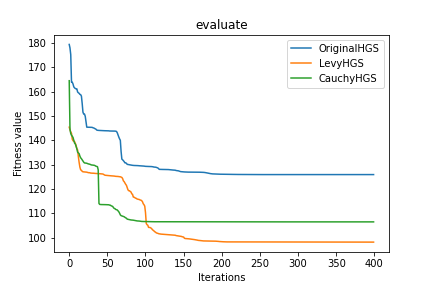

In [ ]:
Image('results/iris.png')

In [ ]:
dataset = pd.read_csv('IRIS.csv')
X = dataset.iloc[:,0:-1].values
model = K_Means(k=3)
model.fit(X)
model.hist[-1]

97.34621969415682

## Blood

In [ ]:
dataset = pd.read_csv('Blood.csv')
dataset.head()

,2,50,12500,98,1
0,0,13,3250,28,1
1,1,16,4000,35,1
2,2,20,5000,45,1
3,1,24,6000,77,0
4,4,4,1000,4,0


In [ ]:
X = dataset.iloc[:,0:-1].values
y = dataset.iloc[:, -1].values
data = X
classes = sorted(list(set(y)))
y = [classes.index(x) for x in y]
print(y)
min_ = []
max_ = []
for i in range(len(data[0])):
    d = [x[i] for x in data]
    min_.append(min(d))
    max_.append(max(d))
k = len(set(y))

[1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 

In [ ]:
dataset_name = 'Blood'
lb1=min_*k
ub1=max_*k
verbose=False
epoch=200
pop_size=50
optimizer1 = [OriginalHGS, LevyHGS, CauchyHGS]
fit = pd.DataFrame()
obj_func = evaluate
for opt in optimizer1:
  print(opt.__name__)
  md = opt(obj_func, lb1, ub1, verbose, epoch, pop_size, problem_size=problem_size)
  best_pos, best_fit, list_loss, hist = md.train()
  print("Fitness value: ", best_fit)
  plt.plot(list_loss, label=opt.__name__)
plt.legend()
plt.title(obj_func.__name__)
plt.xlabel('Iterations')
plt.ylabel('Fitness value')
plt.savefig('results/'+dataset_name+'.png')
plt.close()

OriginalHGS


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in exp


Fitness value:  399433.19277042133
LevyHGS
Fitness value:  399428.6607321986
CauchyHGS
Fitness value:  397883.7632455839


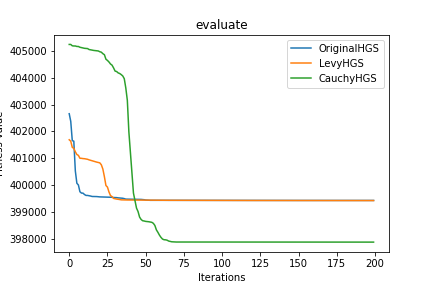

In [ ]:
Image('results/Blood.png')

In [ ]:
dataset = pd.read_csv('Blood.csv')
X = dataset.iloc[:,0:-1].values
model = K_Means(k=2)
model.fit(X)
model.hist[-1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide


458108.4367984831

## Banknote

In [ ]:
dataset = pd.read_csv('banknote.csv')
dataset.head()

,3.6216,8.6661,-2.8073,-0.44699,0
0,4.54590,8.1674,-2.4586,-1.46210,0
1,3.86600,-2.6383,1.9242,0.10645,0
2,3.45660,9.5228,-4.0112,-3.59440,0
3,0.32924,-4.4552,4.5718,-0.98880,0
4,4.36840,9.6718,-3.9606,-3.16250,0


In [ ]:
X = dataset.iloc[:,0:-1].values
y = dataset.iloc[:, -1].values
data = X
classes = sorted(list(set(y)))
y = [classes.index(x) for x in y]
print(y)
min_ = []
max_ = []
for i in range(len(data[0])):
    d = [x[i] for x in data]
    min_.append(min(d))
    max_.append(max(d))
k = len(set(y))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
dataset_name = 'banknote'
lb1=min_*k
ub1=max_*k
verbose=False
epoch=200
pop_size=50
optimizer1 = [OriginalHGS, LevyHGS, CauchyHGS]
fit = pd.DataFrame()
obj_func = evaluate
for opt in optimizer1:
  print(opt.__name__)
  md = opt(obj_func, lb1, ub1, verbose, epoch, pop_size, problem_size=problem_size)
  best_pos, best_fit, list_loss, hist = md.train()
  print("Fitness value: ", best_fit)
  plt.plot(list_loss, label=opt.__name__)
plt.legend()
plt.title(obj_func.__name__)
plt.xlabel('Iterations')
plt.ylabel('Fitness value')
plt.savefig('results/'+dataset_name+'.png')
plt.close()

OriginalHGS


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in exp


Fitness value:  7240.175432379056
LevyHGS
Fitness value:  7217.754689155968
CauchyHGS
Fitness value:  7251.337273902753


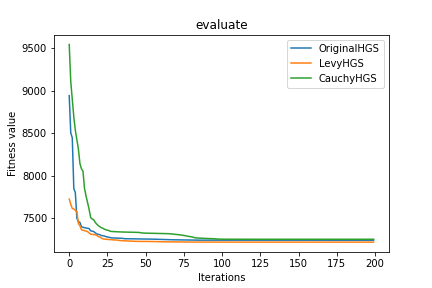

In [ ]:
Image('results/banknote.png')

In [ ]:
dataset = pd.read_csv('banknote.csv')
X = dataset.iloc[:,0:-1].values
model = K_Means(k=2)
model.fit(X)
model.hist[-1]

7241.516211410195

## Wine

In [ ]:
dataset = pd.read_csv('wine.csv')
dataset.head()

,14.23,1.71,2.43,15.6,127,2.8,3.06,0.28,2.29,5.64,1.04,3.92,1065,1
0,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,1
1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,1
2,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,1
3,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,1
4,14.20,1.76,2.45,15.2,112,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450,1


In [ ]:
X = dataset.iloc[:,0:-1].values
y = dataset.iloc[:, -1].values
data = X
classes = sorted(list(set(y)))
y = [classes.index(x) for x in y]
print(y)
min_ = []
max_ = []
for i in range(len(data[0])):
    d = [x[i] for x in data]
    min_.append(min(d))
    max_.append(max(d))
k = len(set(y))

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
dataset_name = 'wine'
lb1=min_*k
ub1=max_*k
verbose=False
epoch=200
pop_size=50
optimizer1 = [OriginalHGS, LevyHGS, CauchyHGS]
fit = pd.DataFrame()
obj_func = evaluate
for opt in optimizer1:
  print(opt.__name__)
  md = opt(obj_func, lb1, ub1, verbose, epoch, pop_size, problem_size=problem_size)
  best_pos, best_fit, list_loss, hist = md.train()
  print("Fitness value: ", best_fit)
  plt.plot(list_loss, label=opt.__name__)
plt.legend()
plt.title(obj_func.__name__)
plt.xlabel('Iterations')
plt.ylabel('Fitness value')
plt.savefig('results/'+dataset_name+'.png')
plt.close()

OriginalHGS


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in exp


Fitness value:  16310.628658273588
LevyHGS
Fitness value:  16451.64925616769
CauchyHGS
Fitness value:  16400.57716000668


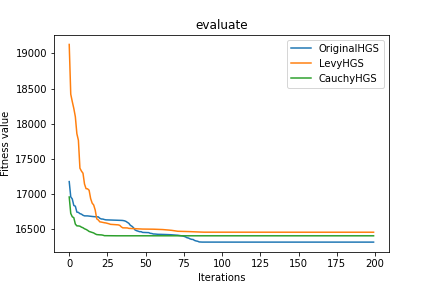

In [ ]:
Image('results/wine.png')

In [ ]:
dataset = pd.read_csv('wine.csv')
X = dataset.iloc[:,0:-1].values
model = K_Means(k=3)
model.fit(X)
model.hist[-1]

18100.762448025536